# Homework Assignment 8

**Question 1:** Select a book or a movie's subtitle, and find the locations that appear in the book/movie. Then, draw these locations on a map (at least 10 locations) (30pt). Connect the discovered locations with lines according to their order of appearance
in the book. For example, if location B appeared immediately after location A, then draw a line connecting locations A and B (20pt).

In [1]:
import spacy
import operator
from geopy.geocoders import Nominatim
from functools import lru_cache
from scipy.interpolate import interp1d
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import turicreate as tc
from shapely.geometry import Point

In [2]:
import operator
import spacy
nlp = spacy.load('en_core_web_lg')


def get_locations_from_text(text):
    locations_dict= {}

    #using spaCy to get entities
    doc = nlp(text)
    order_loc = []
    for entity in doc.ents:
        label = entity.label_
        if label not in {'LOC', 'GPE'}:
            continue
        loc = entity.text.lower().strip()
        if len(loc) < 2:
            continue
        if loc not in locations_dict:
            locations_dict[loc] = 0
        locations_dict[loc] += 1
        
        order_loc.append(loc)
    return locations_dict, order_loc

euro_trip_path = "Euro.Trip.txt"
txt = open(euro_trip_path).read()
locations_dict, order_loc = get_locations_from_text(txt)
locations_dict = {k:v for k,v in  locations_dict.items() if v>1}
print(sorted(locations_dict.items(), key=operator.itemgetter(1), reverse=True)[:20])
print(f"Number of locations {len(locations_dict.keys())}")

[('berlin', 23), ('europe', 22), ('rome', 11), ('paris', 9), ('america', 8), ('coop', 6), ('germany', 6), ('amsterdam', 5), ('ohio', 3), ('bratislava', 3), ('london', 2), ('ities', 2), ('denmark', 2), ('miami', 2), ('leica', 2)]
Number of locations 15


process dict to remove entities that are not locations for map

In [3]:
locations_dict = {k:v for k,v in  locations_dict.items() if v>1 and k not in ('europe','america','coop','leica','ities')}
print(sorted(locations_dict.items(), key=operator.itemgetter(1), reverse=True)[:20])
print(f"Number of locations {len(locations_dict.keys())}")

[('berlin', 23), ('rome', 11), ('paris', 9), ('germany', 6), ('amsterdam', 5), ('ohio', 3), ('bratislava', 3), ('london', 2), ('denmark', 2), ('miami', 2)]
Number of locations 10


In [4]:
geolocator = Nominatim(user_agent="Data Science Education App")
@lru_cache(maxsize=256)
def get_location(loc):
    return geolocator.geocode(loc)

def is_poly_contains_point(poly, l):
    for pt in l:
        if pt.within(poly):
            return True
    return False

In [5]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

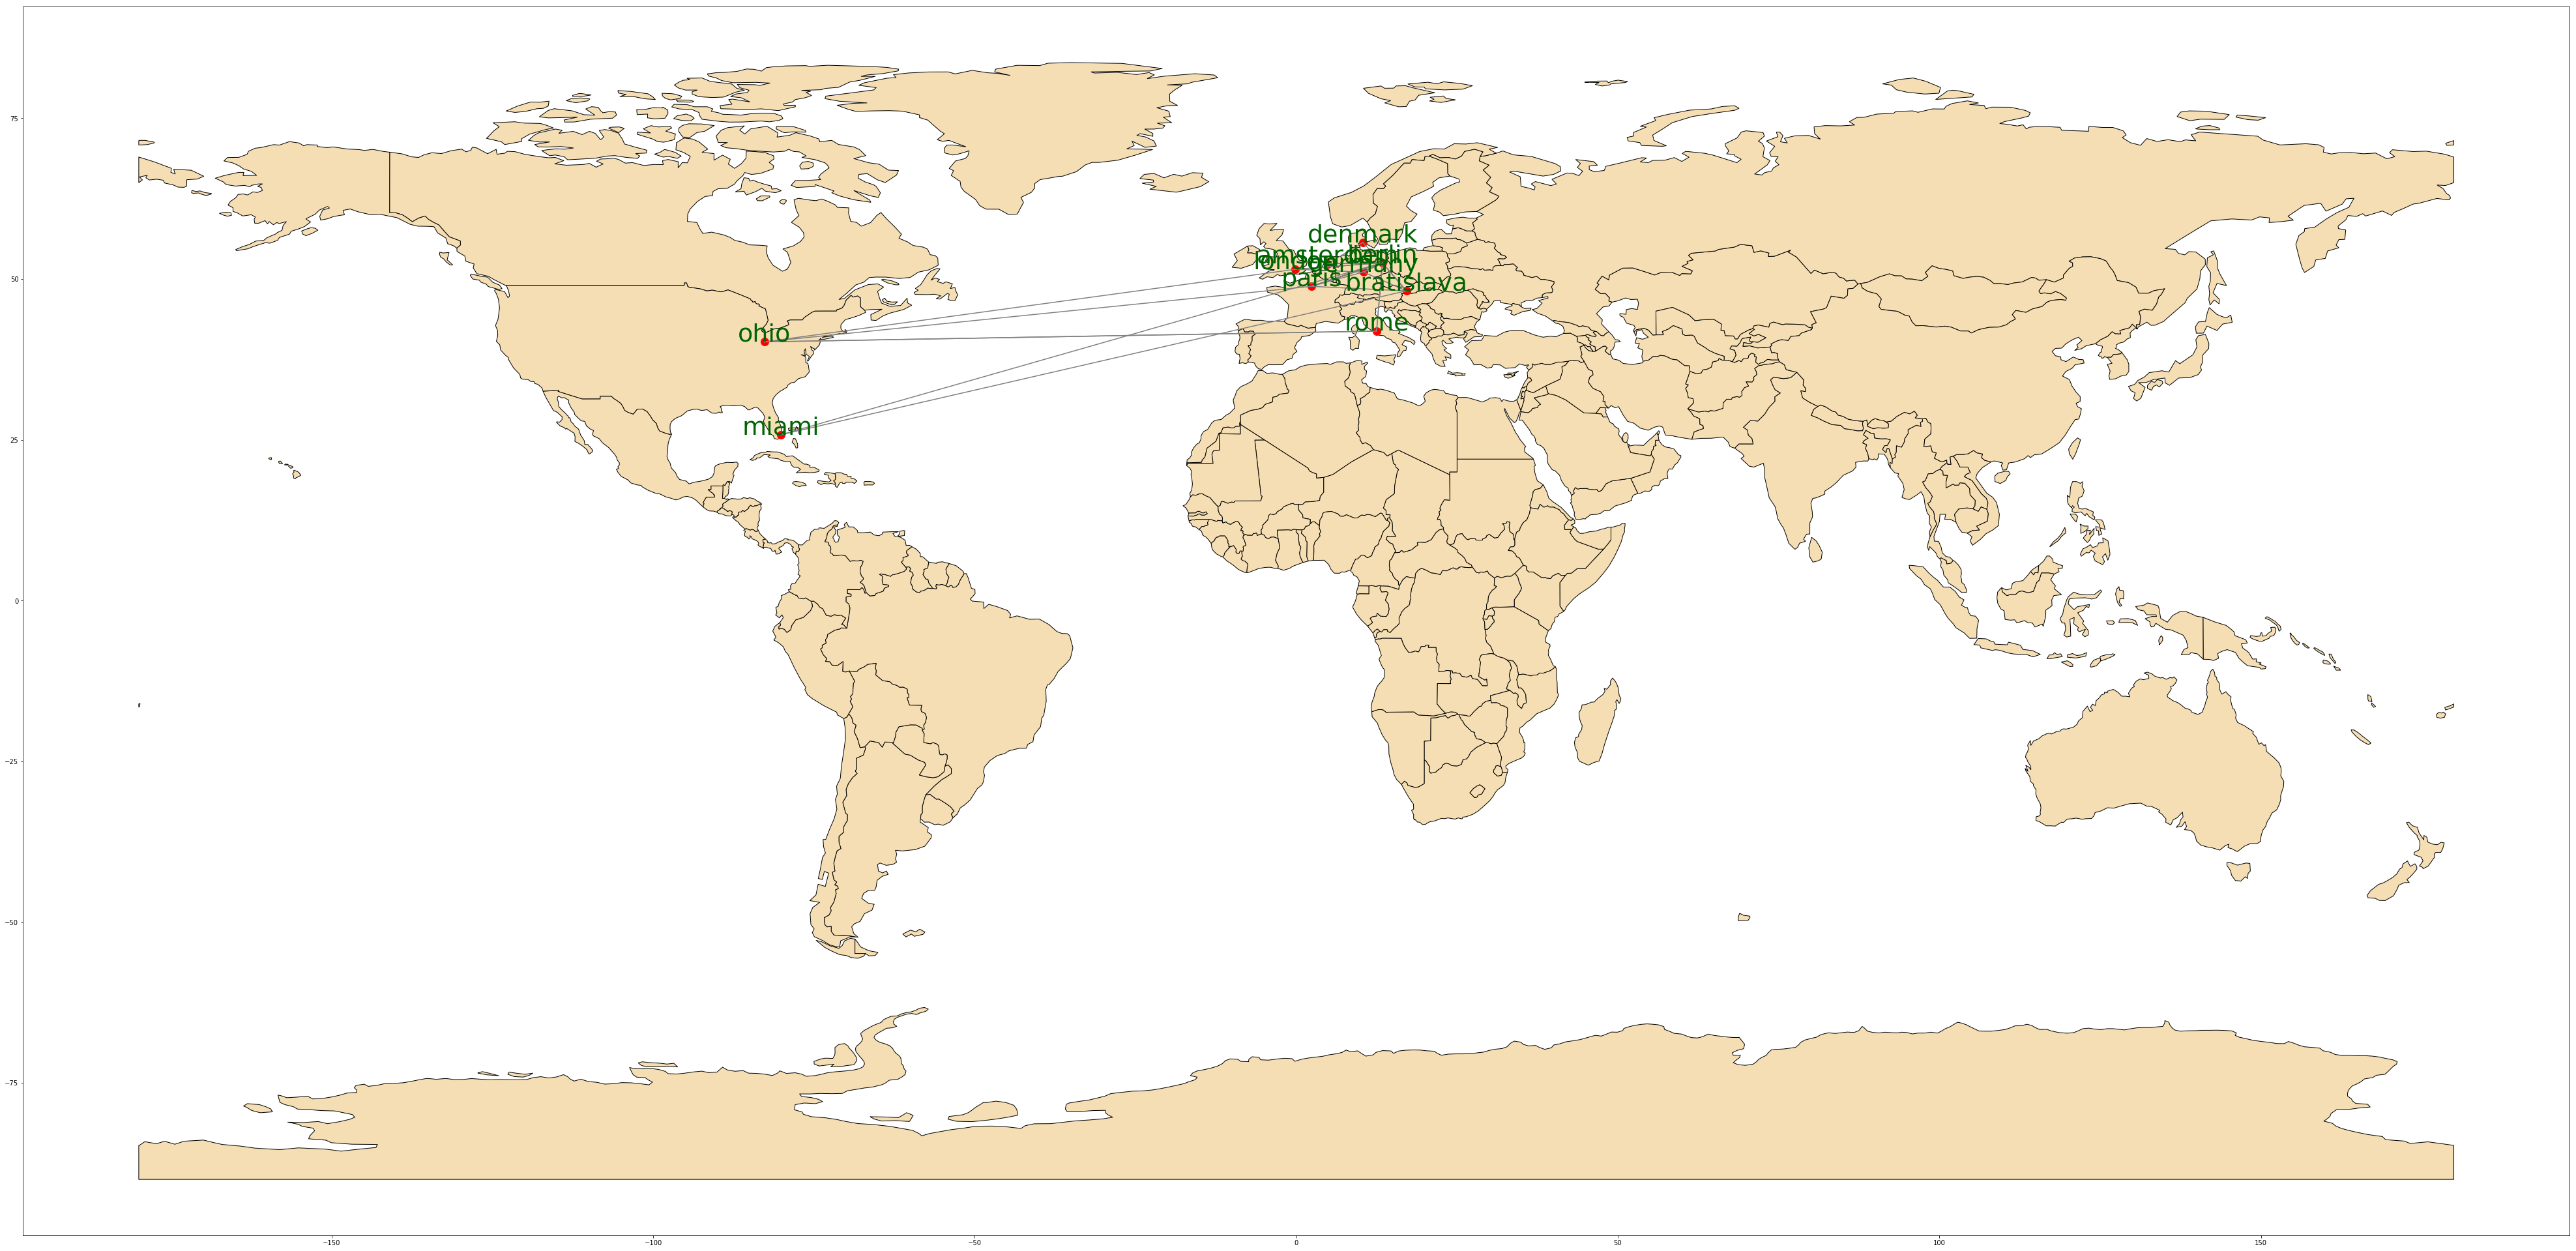

In [6]:
world.plot(color='wheat', edgecolor='black',figsize=(55,155));
plt.tight_layout()
real_loc = []
for loc, v in locations_dict.items():
    location = get_location(loc)
    if location is None:
        continue
    real_loc.append(loc)
    plt.plot(location.longitude,location.latitude, marker='o', color='red', markersize=12)
    plt.annotate(s=loc, xy=(location.longitude, location.latitude+0.1),
                 horizontalalignment='center', fontsize=38, color="darkgreen")


order_loc = [x for x in order_loc if x in real_loc]
loc_links = []
for first, second in zip(order_loc, order_loc[1:]):
    if not first == second:
        loc_links.append((first, second))
        frst = get_location(first)
        sec = get_location(second)
        if frst is None or sec is None:
            continue
        plt.plot([frst.longitude, sec.longitude], [frst.latitude, sec.latitude], color='grey')

**Question 2:** Select a country's' statistic from the [Countries of the World dataset](https://www.kaggle.com/fernandol/countries-of-the-world).
Then, create a choropleth map displaying how the selected statistics changed over time (15pt) 
    
**Bonus:** Create a short animation that displays how the chosen statistics changed over time (10pt)

i used the usa crime dataset from https://www.ucrdatatool.gov/Search/Crime/State/StatebyState.cfm
and with plotly express we can see the change crimes between 1960-2014. ichose rubbey but any crime can be used.

In [7]:
import pandas as pd
import plotly_express as px


/data/home/laadan/anaconda3/envs/BigData/lib/python3.6/site-packages/plotly_express/_doc.py:317: DeprecationWarning:

inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()



In [8]:
df = pd.read_csv('CrimeStatebyState_1960-2014.csv')
df.head()

State  Year  Population  Violent_crime_total  \
0  Alabama  1960     3266740                 6097   
1  Alabama  1961     3302000                 5564   
2  Alabama  1962     3358000                 5283   
3  Alabama  1963     3347000                 6115   
4  Alabama  1964     3407000                 7260   

   Murder_and_nonnegligent_Manslaughter  Murder_per100000  Legacy_rape_/1  \
0                                   406         12.428292             281   
1                                   427         12.931557             252   
2                                   316          9.410363             218   
3                                   340         10.158351             192   
4                                   316          9.275022             397   

   Revised_rape_/2  Robbery  Aggravated_assault State_code  
0              NaN      898                4512         AL  
1              NaN      630                4255         AL  
2              NaN      754                3995         AL  
3              NaN      828                4755         AL  
4              NaN      992                5555         AL

In [9]:
px.choropleth(df, locations='State_code', locationmode='USA-states', color='Robbery', animation_frame='Year')

**Question 3:** Select a request type from [San Francisco 311 dataset](https://www.kaggle.com/datasf/case-data-from-san-francisco-311).
Create an interactive map that somehow presents in which areas this request occurs the most (35pt).

In [10]:
df = pd.read_csv('Case_Data_from_San_Francisco_311__SF311.csv')
df = df[df['Request Type']=='Sidewalk_Cleaning'][['Point']]
df['lat'] = df['Point'].apply(lambda p: float(p[1:-1].split(',')[0]))
df['long'] = df['Point'].apply(lambda p: float(p[1:-1].split(',')[1]))
sf_df = df[['lat','long']]
sf_df.shape

/data/home/laadan/anaconda3/envs/BigData/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.



(171590, 2)

In [11]:
import folium
from folium.plugins import HeatMap

tiles = 'Stamen Terrain'
m = folium.Map(location=[37.76,-122.45], zoom_start=12.5, tiles = tiles)

data = [(r['lat'],r['long']) for i, r in sf_df[:5000].iterrows()]
HeatMap(data, radius = 20).add_to(m)
m